In [1]:
# data frame related packages
import pandas as pd
import numpy as np
from datetime import datetime

# database related packages
import sqlite3

# package for converting words to count values
from sklearn.feature_extraction.text import CountVectorizer


# import LSTM related packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint # for checkpoint of model

# package for zero padding
from keras.preprocessing import sequence

# fix random seed for reproducibility
np.random.seed(7)

# visualization related packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# model evaluation related packages
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

/home/amd_3/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Data Fetching and Preprocessing

In [2]:
db_path = '/home/amd_3/AAIC/ASM_REPO/Processed_data/AMZN_FOOD_REVIW/final.sqlite'
# declare vocabulary size
vocab_size = 9999

In [3]:
def get_number_format_data(db_path, vocab_size):
    
    """
    This function convert the data into a format which is suitable for LSTM training.
    All rows will be converted into a list of numbers
    """
    
    # create a connection object
    con = sqlite3.connect(db_path)

    # read from database
    df_db = pd.read_sql_query('SELECT Time, CleanedText, Label from Reviews', con)
    
    # combine all texts into a bigger text
    temp = str()
    for rev_txt in df_db['CleanedText']:
        temp += rev_txt + ' '
        
    # get BoW represntation to get count of each word
    bow_obj = CountVectorizer()
    count_info = bow_obj.fit_transform([temp])
    
    # get the word and its count in list of tuples form
    word_count_list = list(zip(bow_obj.get_feature_names(), count_info.toarray()[0]))
    
    # sort the data in descending order of count
    sorted_word_cnt_list = sorted(word_count_list, reverse=True, key=lambda x: x[1])[0:vocab_size]
    
    # assign rank to each word
    word_rank_list = [(val[0], index + 1) for index, val in enumerate(sorted_word_cnt_list)]

    # create a dictionary where key = word and value = rank.
    rank_dict = dict(word_rank_list)
    
    
    # declare a list to save number format review for all reviews 
    all_review_num_list = list()

    # process each review one by one
    for rev_txt in df_db['CleanedText']:
    
        # get a list of words
        rev_txt_list = rev_txt.split()

        # declare a list for number format
        num_list = list()

        # get rank representation for each word
        for word in rev_txt_list:
            try:
                num_list.append(rank_dict[word])
            except:
                pass

        # update the list
        all_review_num_list.append(num_list)

    # create the final data frame for LSTM model
    df = pd.DataFrame({'Features': all_review_num_list,
                   'Label': df_db['Label'], 'Time': df_db['Time']})
    # align the columns of data frame
    df = df[['Time', 'Features', 'Label']]

    # remove all zero lenght reviews
    df = df[df['Features'].apply(len) > 0 ]
    
    return df

In [4]:
start_ts = datetime.now()
final_df = get_number_format_data(db_path, vocab_size)
end_ts = datetime.now()
print('Total time', end_ts - start_ts)

Total time 0:00:18.003695


In [5]:
final_df.head()

,Time,Features,Label
0,939340800,"[30, 1076, 17, 362, 2383, 3193, 1111, 1188, 53...",1
1,940809600,"[530, 137, 652, 937, 6302, 46, 303, 968, 1131,...",1
2,944092800,"[4339, 36, 1975, 1203, 334, 166, 1776, 447, 46...",1
3,944438400,"[1550, 3808, 2599, 184, 2531, 5705, 8127, 5801...",1
4,946857600,"[4339, 166, 1414, 1203, 5705, 5373, 4339, 10, ...",1


In [6]:
def get_train_test_split(final_df):
    """
    This function split the data into train and test. It balances the train data.
    """

    # consider first 237800 points for generating train sample and remaining for  test samples.
    # within 237800 points we have 35000 - ve samples and others are +ve, from this set we
    # can take a sample of 35000 +ve, so we will have a balanced data set having 35K +ve, 35K -ve
    # points which is apt for training the model

    # partiton the data for train, test data set generation
    final_df_train = final_df[0:237800]
    final_df_test = final_df[237800:]

    # partition the data frame to positive and negative
    final_df_positive = final_df_train[final_df_train['Label'] == 1]
    final_df_negative = final_df_train[final_df_train['Label'] == 0]

    # since positive sample is dominating we select 30K samples randomly from the positive partiion &
    #  take whole negative samples
    final_df_positive = final_df_positive.sample(n=35000)

    # form train sample set
    final_train_df = final_df_positive.append(final_df_negative)
    final_train_df = final_train_df.sample(frac=1.0)
    final_train_df = final_train_df.reset_index(drop=True)

    # sample 30K points for testing
    final_test_df = final_df_test.sample(n=30000)
    final_test_df = final_test_df.reset_index(drop=True)

    print('Final train df statistics:\n', final_train_df['Label'].value_counts())
    print('\n\nFinal test df statistics:\n', final_test_df['Label'].value_counts())
    
    return (final_train_df, final_test_df,)

In [7]:
final_train_df, final_test_df = get_train_test_split(final_df)

Final train df statistics:
 1    35000
0    34997
Name: Label, dtype: int64


Final test df statistics:
 1    24675
0     5325
Name: Label, dtype: int64


In [8]:
final_test_df.head()

,Time,Features,Label
0,1344816000,"[137, 553, 591, 693, 7, 258, 599, 431, 1832, 8...",1
1,1325980800,"[8, 85, 1627, 2060, 357, 1286, 8522, 45, 120, ...",1
2,1337126400,"[383, 19, 532, 39, 141, 95, 1828, 51, 539, 405...",1
3,1349740800,"[4374, 2102, 15, 3997, 2171, 130, 159, 15, 193...",1
4,1347408000,"[72, 919, 1, 35, 13, 2551, 3565, 51, 744, 101,...",1


In [9]:
# get train dataset
y_train = final_train_df['Label']
X_train = final_train_df['Features'].values
# get test dataset
y_test = final_test_df['Label']
X_test = final_test_df['Features'].values

In [10]:
max_seq_length = 900
X_train = sequence.pad_sequences(X_train, maxlen=max_seq_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_seq_length)

print(X_train.shape)
print(X_train[1])

(69997, 900)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    

# UTIL functions

In [11]:
def plot_loss_curve(train_metric_list, val_metric_list):
    """
    This function plots the loss curve
    """
    
    # get x-label list
    epcoh_list = range(1, len(train_metric_list) + 1 )
    
    # get train_accuracy data
    train_acc_list = [ item[0] for item in train_metric_list]
    
    # get validation accuracy data
    val_acc_list = [ item[0] for item in val_metric_list]
    
    # plot both train, validation curve
    plt.plot(epcoh_list, train_acc_list, label='Train Loss', color='r')
    plt.plot(epcoh_list, val_acc_list, label='Validation Loss', color='b')
    plt.xlabel('Training Epoch')
    plt.ylabel('Cross Entropy Error')
    plt.title('Training Loss Vs Validation Loss')
    plt.legend()
    plt.show()

In [12]:
def plot_accuracy_curve(train_metric_list, val_metric_list):
    """
    This is a helper function for plotting accuracy
    """
    
    # get x-label list
    epcoh_list = range(1, len(train_metric_list) + 1 )
    
    # get train_accuracy data
    train_acc_list = [ item[1] for item in train_metric_list]
    
    # get validation accuracy data
    val_acc_list = [ item[1] for item in val_metric_list]
    
    # plot both train, validation curve
    plt.plot(epcoh_list, train_acc_list, label='Train Accuracy', color='r')
    plt.plot(epcoh_list, val_acc_list, label='Validation Accuracy', color='b')
    plt.xlabel('Training Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy Vs Validation Accuracy')
    plt.legend()
    plt.show()

In [13]:
def get_confusion_matrix(actual_list, predicted_list, cm_title):
    """
    This function plots confusion matrix for test data set
    """

    conf_matrix = confusion_matrix(actual_list, predicted_list)
    col_names = ['Negative', 'Positive']
    conf_df = pd.DataFrame(conf_matrix,columns=col_names)
    conf_df.index = col_names

    plt.figure(figsize = (5,5))

    plt.title(cm_title)
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(conf_df, annot=True, annot_kws={"size": 16}, fmt='g')

    plt.show()

# MODEL

In [14]:
vocabulary_size = 10000
max_input_length = 900

## A) Single layered LSTM Architecture

In [15]:
def single_layer_lstm(h_params, vocabulary_size, max_input_length):
    """
    A function which builds single layered LSTM
    """
    
    # define the embedding length
    embedding_vecor_length = 32
    
    # set the number of LSTM units for each layer
    drop_rate = h_params[0]
    num_hidden_units_1 = h_params[1]
    
    # declare the model
    model = Sequential()
    
    # add layers to the model
    model.add(Embedding(vocabulary_size, embedding_vecor_length, input_length=max_input_length))
    model.add(LSTM(num_hidden_units_1))
    model.add(Dropout(drop_rate))
    model.add(Dense(1, activation='sigmoid'))

    print(model.summary())
    
    return model

## B) Multilayered LSTM Architecture

In [16]:
def multi_layer_lstm(h_params, vocabulary_size, max_input_length):
    
    """
    A function which builds multi layered (2-layers) LSTM
    """
    
    # define the embedding length
    embedding_vecor_length = 32
    
    # set the number of LSTM units for each layer
    drop_rate = h_params[0]
    num_hidden_units_1 = h_params[1]
    num_hidden_units_2 = h_params[2]
    
    
    # declare the model
    model = Sequential()
    
    # add layers to the model
    model.add(Embedding(vocabulary_size, embedding_vecor_length, input_length=max_input_length))
    model.add(LSTM(num_hidden_units_1, return_sequences=True))
    model.add(LSTM(num_hidden_units_2))
    model.add(Dropout(drop_rate)) # dropout layer for reducing overfit
    model.add(Dense(1, activation='sigmoid'))

    print(model.summary())
    
    return model

## UTIL function to train models

In [17]:
def train_and_evaluate_model(model, model_file_path, num_epochs, X_train, y_train, X_test, y_test):
    """
    This function train a given model and evaluate its performance on test data set
    """
    
    # set the loss function, optimizer and evaluation metric
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # monitor the performace of model on  every epoch
    checkpoint = ModelCheckpoint(model_file_path, monitor='val_loss', verbose=1,
                                 save_best_only=True, mode='auto')
    callbacks_list = [checkpoint]


    # Train the model
    hist_obj = model.fit(X_train, y_train, nb_epoch=num_epochs, batch_size=128, validation_split=0.20,
                         callbacks=callbacks_list)
    hist_obj = hist_obj.history

    # load weights from the saved model
    model.load_weights(model_file_path)

    # Compile model (required to make predictions)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print('Restored best model weights from saved file')

    train_metric_list = list(zip(hist_obj['loss'], hist_obj['acc']))
    validation_metric_list = list(zip(hist_obj['val_loss'], hist_obj['val_acc']))

    # plot the performace
    plot_loss_curve(train_metric_list, validation_metric_list)
    plot_accuracy_curve(train_metric_list, validation_metric_list)

    # get the loss and accuracy on test data
    scores = model.evaluate(X_test, y_test, verbose=0)
    scores[1] *= 100
    print('Test loss:%f, Test Accuracy:%f'%tuple(scores))

    # predict the test data points class
    predicted = model.predict_classes(X_test)

    # compute precision, recall, fscore and class support values
    all_metrics = precision_recall_fscore_support(y_test, predicted.flatten())

    # create a data frame having records of all the above metrics
    all_metrics_df = pd.DataFrame(list(all_metrics), columns=['Negative', 'Positive'])
    all_metrics_df.index = ['Precision', 'Recall', 'Fscore', 'Support']

    fscores = all_metrics[2]
    fscores *=  100

    # display the confusion matrix
    cm_title = 'LSTM Confusion Matrix'
    get_confusion_matrix(y_test, predicted, cm_title)

    print(all_metrics_df.head())

    # return all the required test metrics, to save in a table
    test_metrics = scores + list(fscores)

    # round all results upto four decimal places
    test_metrics = [ '%.4f' % item for item in test_metrics]

    return test_metrics


## Train and Evaluate each model

### a) Single layered architecture 1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 900, 32)           320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 80)                36160     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 81        
Total params: 356,241
Trainable params: 356,241
Non-trainable params: 0
_________________________________________________________________
None


/home/amd_3/anaconda3/lib/python3.6/site-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 55997 samples, validate on 14000 samples
Epoch 1/5
55997/55997 [==============================] - 762s 14ms/step - loss: 0.3713 - acc: 0.8373 - val_loss: 0.2939 - val_acc: 0.8841
Epoch 2/5
55997/55997 [==============================] - 788s 14ms/step - loss: 0.2675 - acc: 0.8952 - val_loss: 0.2960 - val_acc: 0.8812
Epoch 3/5
55997/55997 [==============================] - 791s 14ms/step - loss: 0.2430 - acc: 0.9051 - val_loss: 0.3056 - val_acc: 0.8797
Epoch 4/5
55997/55997 [==============================] - 817s 15ms/step - loss: 0.2231 - acc: 0.9150 - val_loss: 0.3066 - val_acc: 0.8800
Epoch 5/5
55997/55997 [==============================] - 857s 15ms/step - loss: 0.2011 - acc: 0.9242 - val_loss: 0.3162 - val_acc: 0.8788
Restored best model weights from saved file


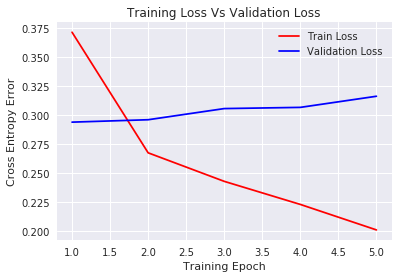

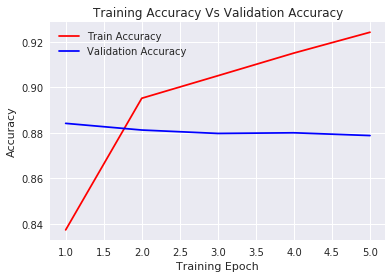

Test loss:0.324790, Test Accuracy:86.546667


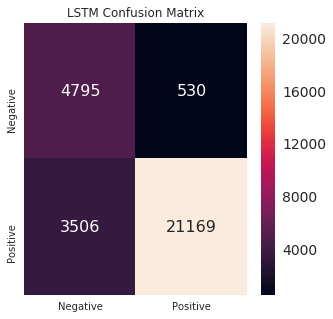

              Negative      Positive
Precision     0.577641      0.975575
Recall        0.900469      0.857913
Fscore        0.703802      0.912968
Support    5325.000000  24675.000000


In [18]:
# crete model object
h_params_s_a1 = (0.10, 80,)
model_obj = single_layer_lstm(h_params_s_a1, vocabulary_size, max_input_length)

# checkpoint
num_epochs = 5
model_file_path = 'single_a1_weights.best.hdf5'
# train and evaluate the model
test_metrics_s_a1 = train_and_evaluate_model(model_obj, model_file_path, num_epochs, X_train, y_train, 
                                             X_test, y_test)

### b) Single layered architecture 2

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 900, 32)           320000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 373,301
Trainable params: 373,301
Non-trainable params: 0
_________________________________________________________________
None


/home/amd_3/anaconda3/lib/python3.6/site-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 55997 samples, validate on 14000 samples
Epoch 1/5
55997/55997 [==============================] - 1036s 18ms/step - loss: 0.3725 - acc: 0.8368 - val_loss: 0.3051 - val_acc: 0.8764
Epoch 2/5
55997/55997 [==============================] - 955s 17ms/step - loss: 0.2684 - acc: 0.8943 - val_loss: 0.2991 - val_acc: 0.8783
Epoch 3/5
55997/55997 [==============================] - 949s 17ms/step - loss: 0.2419 - acc: 0.9045 - val_loss: 0.2995 - val_acc: 0.8790
Epoch 4/5
55997/55997 [==============================] - 958s 17ms/step - loss: 0.2238 - acc: 0.9129 - val_loss: 0.3099 - val_acc: 0.8793
Epoch 5/5
55997/55997 [==============================] - 950s 17ms/step - loss: 0.2042 - acc: 0.9223 - val_loss: 0.3172 - val_acc: 0.8762
Restored best model weights from saved file


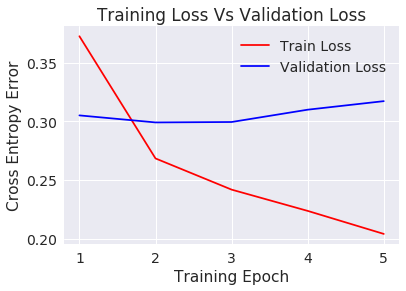

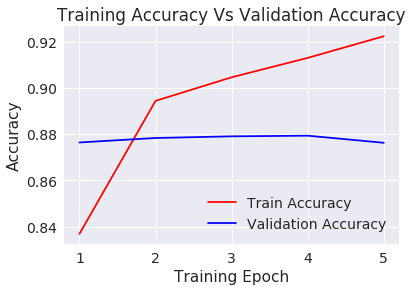

Test loss:0.313953, Test Accuracy:86.716667


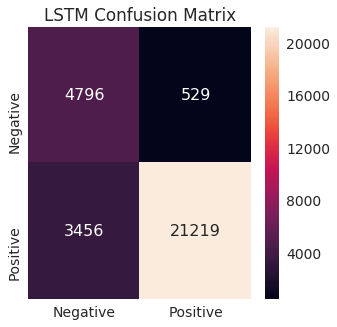

              Negative      Positive
Precision     0.581192      0.975676
Recall        0.900657      0.859939
Fscore        0.706489      0.914159
Support    5325.000000  24675.000000


In [19]:
# crete model object
h_params_s_a2 = (0.15, 100,)
model_obj = single_layer_lstm(h_params_s_a2, vocabulary_size, max_input_length)

# checkpoint
num_epochs = 5
model_file_path = 'single_a2_weights.best.hdf5'
# train and evaluate the model
test_metrics_s_a2 = train_and_evaluate_model(model_obj, model_file_path, num_epochs, X_train, y_train, 
                                             X_test, y_test)

### c) Multi layered architecture 1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 900, 32)           320000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 900, 64)           24832     
_________________________________________________________________
lstm_4 (LSTM)                (None, 20)                6800      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 351,653
Trainable params: 351,653
Non-trainable params: 0
_________________________________________________________________
None


/home/amd_3/anaconda3/lib/python3.6/site-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 55997 samples, validate on 14000 samples
Epoch 1/5
55997/55997 [==============================] - 924s 16ms/step - loss: 0.4185 - acc: 0.8126 - val_loss: 0.3495 - val_acc: 0.8503
Epoch 2/5
55997/55997 [==============================] - 913s 16ms/step - loss: 0.2824 - acc: 0.8891 - val_loss: 0.2949 - val_acc: 0.8788
Epoch 3/5
55997/55997 [==============================] - 955s 17ms/step - loss: 0.2451 - acc: 0.9055 - val_loss: 0.2968 - val_acc: 0.8802
Epoch 4/5
55997/55997 [==============================] - 991s 18ms/step - loss: 0.2203 - acc: 0.9175 - val_loss: 0.3013 - val_acc: 0.8809
Epoch 5/5
55997/55997 [==============================] - 1085s 19ms/step - loss: 0.1982 - acc: 0.9270 - val_loss: 0.3059 - val_acc: 0.8823
Restored best model weights from saved file


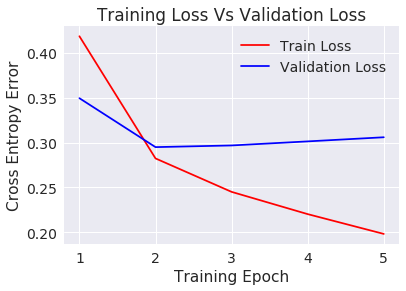

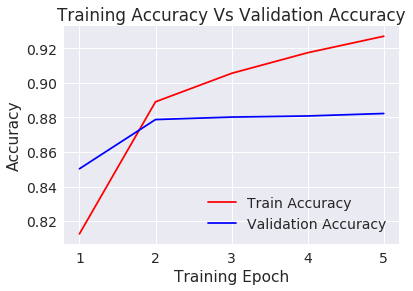

Test loss:0.310434, Test Accuracy:86.960000


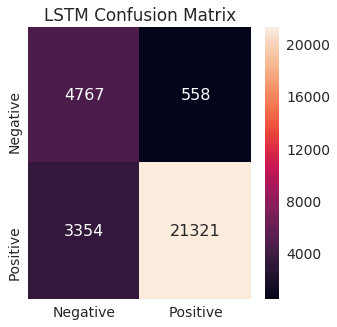

              Negative      Positive
Precision     0.586997      0.974496
Recall        0.895211      0.864073
Fscore        0.709058      0.915969
Support    5325.000000  24675.000000


In [20]:
# crete model object
h_params_m_a1 = (0.10, 64, 20)
model_obj = multi_layer_lstm(h_params_m_a1, vocabulary_size, max_input_length)

# checkpoint
num_epochs = 5
model_file_path = 'multi_a1_weights.best.hdf5'
# train and evaluate the model
test_metrics_m_a1 = train_and_evaluate_model(model_obj, model_file_path, num_epochs, X_train, y_train,
                                             X_test, y_test)

### d) Multi layered architecture 2

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 900, 32)           320000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 900, 100)          53200     
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 390,257
Trainable params: 390,257
Non-trainable params: 0
_________________________________________________________________
None


/home/amd_3/anaconda3/lib/python3.6/site-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 55997 samples, validate on 14000 samples
Epoch 1/5
55997/55997 [==============================] - 1753s 31ms/step - loss: 0.3728 - acc: 0.8343 - val_loss: 0.3067 - val_acc: 0.8757
Epoch 2/5
55997/55997 [==============================] - 1824s 33ms/step - loss: 0.2742 - acc: 0.8912 - val_loss: 0.2955 - val_acc: 0.8796
Epoch 3/5
55997/55997 [==============================] - 1646s 29ms/step - loss: 0.2409 - acc: 0.9074 - val_loss: 0.2940 - val_acc: 0.8815
Epoch 4/5
55997/55997 [==============================] - 1557s 28ms/step - loss: 0.2166 - acc: 0.9175 - val_loss: 0.2955 - val_acc: 0.8811
Epoch 5/5
55997/55997 [==============================] - 1643s 29ms/step - loss: 0.1941 - acc: 0.9272 - val_loss: 0.3001 - val_acc: 0.8793
Restored best model weights from saved file


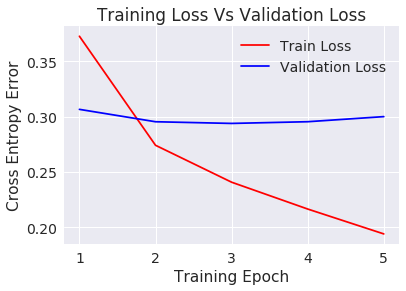

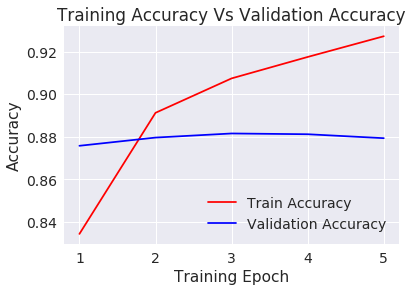

Test loss:0.292912, Test Accuracy:87.770000


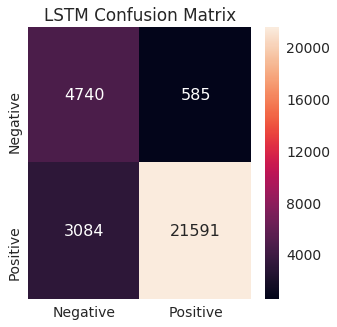

              Negative      Positive
Precision     0.605828      0.973620
Recall        0.890141      0.875015
Fscore        0.720967      0.921688
Support    5325.000000  24675.000000


In [21]:
# crete model object
h_params_m_a2 = (0.15, 100, 32)
model_obj = multi_layer_lstm(h_params_m_a2, vocabulary_size, max_input_length)

# checkpoint
num_epochs = 5
model_file_path = 'multi_a2_weights.best.hdf5'
# train and evaluate the model
test_metrics_m_a2 = train_and_evaluate_model(model_obj, model_file_path, num_epochs, X_train, y_train,
                                             X_test, y_test)

# Observations

%%HTML
<ul>
<li> From the loss curve, Single layered model tend to overfit after epcoh 2 </li>
<li> From the loss curve, Multi layered model tend to overfit after epcoh 3 </li>
<li> For both single layered, multilayered version models the positive class fscore is close to 90 %
     where as for -ve class it is close to 69%</li>
<li> Since precision is low for -ve class, most of the data points the model predicts as -ve are actually not
     negative.
<li> Since dropout value did not help well to reduce overfit, early stopping method can be tried.
</ul>

# Procedure Summary

%%HTML
<ol>
<li> Fetch reviews from the data base and prepare the dataset in a sequence of number format
     which is suitable for keras LSTM model training</li>
<li> Design different LSTM models having different architectures (single layer, multiple layer,
     different dropout rate, different number of cells etc.) </li>
<li> Train &  Evaluate the model on the prepared dataset. </li>
</ol>

# Results Summary

In [22]:
from prettytable import PrettyTable

In [23]:
ptable = PrettyTable()
ptable.title = 'Comparison of LSTM Models'
ptable.field_names = ['Model', 'Loss', 'Accuracy', 'F1-Score (-ve)', 'F1-Score (+ve)']

In [24]:
ptable.add_row(['1-Layer - ' + str(h_params_s_a1)] + test_metrics_s_a1)
ptable.add_row(['1-Layer - ' + str(h_params_s_a2)] + test_metrics_s_a2)
ptable.add_row(['2-Layer - ' + str(h_params_m_a1)] + test_metrics_m_a1)
ptable.add_row(['2-Layer - ' + str(h_params_m_a2)] + test_metrics_m_a2)

In [25]:
print(ptable)

+---------------------------------------------------------------------------------+
|                            Comparison of LSTM Models                            |
+---------------------------+--------+----------+----------------+----------------+
|           Model           |  Loss  | Accuracy | F1-Score (-ve) | F1-Score (+ve) |
+---------------------------+--------+----------+----------------+----------------+
|    1-Layer - (0.1, 80)    | 0.3248 | 86.5467  |    70.3802     |    91.2968     |
|   1-Layer - (0.15, 100)   | 0.3140 | 86.7167  |    70.6489     |    91.4159     |
|  2-Layer - (0.1, 64, 20)  | 0.3104 | 86.9600  |    70.9058     |    91.5969     |
| 2-Layer - (0.15, 100, 32) | 0.2929 | 87.7700  |    72.0967     |    92.1688     |
+---------------------------+--------+----------+----------------+----------------+


# Conclusion

%%HTML
<ul>
<li> All models performed well on +ve class with above 91% f-score</li>
<li> The best F-score for negative class is 72.09% and +ve class is 92.16%  model: (2-Layer - (0.15, 100, 32)) </li>
<li> More feature engineering methods can be tried to improve the negative class performance </li>
</ul>